In [7]:
#ico class
import os
import numpy as np
import nibabel as nb
import copy
import time
from scipy import sparse 
import meld_classifier.mesh_tools as mt
import torch
from math import pi 
import logging


#loads in all icosphere
class IcoSpheres():
    """Class to define cohort-level parameters such as subject ids, mesh"""
    def __init__(self, icosphere_path='../data/icospheres/', distance_type=None,conv_type='SpiralConv', **kwargs):
        """icosphere class
        icospheres at each level are stored in self.icospheres[1:7]
        distance_type = 'exact' or 'pseudo' 
        exact - edge length and flattened relative angle
        pseudo - relative polar coordinates
        conv_type - GMMConv or SpiralConv
        autoloads & calculates:
        'coords': spherical coordinates
        'faces': triangle faces
        'polar_coords': theta & phi spherical coords
        'edges': all edges
        'adj_mat': sparse adjacency matrix
        """
        # TODO already gets combine_hemis as input, can use that to choose edges file
        self.log = logging.getLogger(__name__)
        self.icosphere_path = icosphere_path
        self.icospheres={}
        self.conv_type = conv_type
        self.distance_type = distance_type
        self.log.info(f'Using coord type {self.distance_type}')
        self.load_all_levels()
        
    def load_all_levels(self):
        for level in np.arange(7)+1:
            self.load_one_level(level=level)
            
        return
    
    def load_one_level(self,level=7):
        self.load_icosphere(level = level)
        self.calculate_neighbours(level = level)
        self.spherical_coords(level = level)
        self.get_exact_edge_attrs(level=level)
        self.calculate_adj_mat(level=level)
        if self.conv_type=='SpiralConv':
            self.create_spirals(level=level)
        elif self.conv_type =='GMMConv':
            if self.distance_type=='pseudo':
                self.calculate_pseudo_edge_attrs(level = level)
        
        return
        
    def load_icosphere(self,level=7):
        surf_nb = nb.load(os.path.join(self.icosphere_path,f'ico{level}.surf.gii'))
        self.icospheres[level]={'coords':surf_nb.darrays[0].data,
              'faces':surf_nb.darrays[1].data}
        return 
    
    def calculate_adj_mat(self,level=7):
        surf=self.icospheres[level]
        
        surf['adj_mat'] = sparse.coo_matrix(
                (np.ones(len(surf['edges']), np.uint8), (surf['edges'][:, 0], surf['edges'][:, 1])),
                shape=(len(surf["coords"]), len(surf["coords"])),
            ).tocsr()
        return
    
    def calculate_neighbours(self,level=7):
        file_path = os.path.join(self.icosphere_path,f'ico{level}.neighbours.npy')
        if os.path.isfile(file_path):
            self.icospheres[level]['neighbours'] = np.load(file_path,allow_pickle=True)
        else:            
            self.icospheres[level]['neighbours'] = np.array(self.get_neighbours_from_tris(self.icospheres[level]['faces']),
                                                        dtype=object)
            np.save(file_path,self.icospheres[level]['neighbours'],allow_pickle=True)
        
        return

    def spherical_coords(self,level=7):
        self.icospheres[level]['spherical_coords'] = mt.spherical_np(self.icospheres[level]['coords'])[:,1:]
        self.icospheres[level]['spherical_coords'][:,0] = self.icospheres[level]['spherical_coords'][:,0] - pi/2
        return
    
    def calculate_pseudo_edge_attrs(self,level=7):
        """pseudo edge attributes, difference between latitude and longitude"""
        file_path = os.path.join(self.icosphere_path,f'ico{level}.pseudo.npy')
        if os.path.isfile(file_path):
            pseudo=np.load(file_path)
        else:
            col = self.icospheres[level]['edges'][:,0]
            row = self.icospheres[level]['edges'][:,1]
            pos = self.icospheres[level]['spherical_coords']
            pseudo = pos[col] - pos[row]
            alpha = pseudo[:,1]
            tmp = (alpha == 0).nonzero()[0]
            alpha[tmp] = 1e-15
            tmp = (alpha < 0).nonzero()[0]
            alpha[tmp] = np.pi + alpha[tmp]
            alpha = 2*np.pi + alpha
            alpha = np.remainder(alpha, 2*np.pi)
            pseudo[:,1]=alpha
        self.icospheres[level]['pseudo_edge_attr'] = pseudo
        self.icospheres[level]['t_pseudo_edge_attr'] = torch.tensor(self.icospheres[level]['pseudo_edge_attr'], dtype=torch.float)

        return

    def to(self, device):
        """loads edges, edge vectors and neighbors to device (eg GPU)"""
        for level in self.icospheres.keys():
            self.icospheres[level]['t_edges']=self.icospheres[level]['t_edges'].to(device)
            if self.conv_type=='SpiralConv':
                self.icospheres[level]['spirals']=self.icospheres[level]['spirals'].to(device)
            elif self.conv_type=='GMMConv':
                if self.distance_type=='exact':
                    self.icospheres[level]['t_exact_edge_attr']=self.icospheres[level]['t_exact_edge_attr'].to(device)
                elif self.distance_type=='pseudo':
                    self.icospheres[level]['t_pseudo_edge_attr']=self.icospheres[level]['t_pseudo_edge_attr'].to(device)
            
        return
        
    #helper functions
    def get_edges(self,level=7):
        """returns edges tensor"""
        return self.icospheres[level]['t_edges']
    
    def get_edge_vectors(self,level=7):
        if self.distance_type == 'pseudo':
            return self.icospheres[level]['t_pseudo_edge_attr']
        elif self.distance_type == 'exact':
            return self.icospheres[level]['t_exact_edge_attr']


    
    def get_neighbours_from_tris(self,tris):
        """Get surface neighbours from tris
        Input: tris
        Returns Nested list. Each list corresponds
        to the ordered neighbours for the given vertex"""
        n_vert = np.max(tris) + 1
        neighbours = [[] for i in range(n_vert)]
        for tri in tris:
            neighbours[tri[0]].append([tri[1], tri[2]])
            neighbours[tri[2]].append([tri[0], tri[1]])
            neighbours[tri[1]].append([tri[2], tri[0]])
        # Get unique neighbours
        for k in range(len(neighbours)):
            neighbours[k] = self.sort_neighbours(neighbours[k])
        return neighbours
    
    def sort_neighbours(self,edges):
        edges=np.vstack(edges)
        n0=edges[0][0]
        sorted_neighbours=np.zeros(len(edges),dtype=int)
        for e_i in np.arange(len(edges)):
            n0 =  edges[:,1][edges[:,0]==n0][0]
            sorted_neighbours[e_i]=n0
        return sorted_neighbours

    
    def findAnglesBetweenTwoVectors1(self,v1s, v2s):
        dot = np.einsum('ijk,ijk->ij',[v1s,v1s,v2s],[v2s,v1s,v2s])
        return np.arccos(dot[0,:]/(np.sqrt(dot[1,:])*np.sqrt(dot[2,:])))

    def calculate_angles_and_dists(self,vertex,neighbours,coords):
        angles=np.zeros(len(neighbours))
        v1=coords[neighbours] - coords[vertex]
        v2=coords[np.roll(neighbours,1)]-coords[vertex]
        angles=self.findAnglesBetweenTwoVectors1(v1,v2)
        total_angle=angles.sum()
        angles_flattened = 2*pi*angles.cumsum()/total_angle
        return angles_flattened, np.linalg.norm(v1,axis=1)

    def vertex_attributes(self,surf,vertex):
        neighbours=surf['neighbours'][vertex]
        edges = self.neighbours_to_edges(vertex,neighbours)
        angles,dists = self.calculate_angles_and_dists(vertex,neighbours,surf['coords'])
        #add self edge with almost zero vals
        edge_attrs=np.vstack([[1e-15,1e-15],np.vstack([angles,dists]).T])
        combined=np.hstack([edges,edge_attrs])
        return combined

    def neighbours_to_edges(self,vertex,neighbours):
        """generate paired ordered list of vertex to neighbours, including self edge"""
        edges=np.vstack([[vertex,vertex],np.vstack([np.repeat(vertex,len(neighbours)),neighbours]).T])
        return edges
    
    def get_exact_edge_attrs(self,level=7):
        file_path = os.path.join(self.icosphere_path,f'ico{level}.edges_and_attrs.npy')
        if os.path.isfile(file_path):
            edges_attrs = np.load(file_path)
        else:            
            edges_attrs = self.calculate_exact_edge_attrs(level=level)
            np.save(file_path,edges_attrs)
        self.icospheres[level]['edges'] = edges_attrs[:,:2].astype(int)
        self.icospheres[level]['exact_edge_attr'] = edges_attrs[:,2:]
        # add tensors needed for model
        self.icospheres[level]['t_edges'] = torch.tensor(self.icospheres[level]['edges'], dtype=torch.long).t().contiguous()
        self.icospheres[level]['t_exact_edge_attr'] = torch.tensor(self.icospheres[level]['exact_edge_attr'], dtype=torch.float)
        return
    
    def calculate_exact_edge_attrs(self,level=7):
        surf = self.icospheres[level]
        n_vert = len(surf['coords'])
        all_edge_attrs=[]
        for v in np.arange(n_vert):
            edge_attrs=self.vertex_attributes(surf,v)
            all_edge_attrs.append(edge_attrs)
        all_edge_attrs = np.vstack(all_edge_attrs)
        return all_edge_attrs

    
    def get_neighbours(self,level=7):
        """return 7*n_vertex array of neighbours, with self neighbours 
        and repeated self index if only 5 neighbours"""
        if 't_neighbours'  not in self.icospheres[level].keys():
            self.icospheres[level]['t_neighbours'] = np.tile(np.arange(len(self.icospheres[level]['coords'])),(7,1)).T
            for ni,n in enumerate(self.icospheres[level]['neighbours']):
                self.icospheres[level]['t_neighbours'][ni,-len(n):]=n
            self.icospheres[level]['t_neighbours'] = torch.tensor(self.icospheres[level]['t_neighbours'],dtype=torch.long)
        return self.icospheres[level]['t_neighbours']
    
    def get_upsample(self,target_level=7):
        """provide edges new vertices in mesh upsampled to the target level
        returns array (len(new_level)-len(old_level),2)
        with 2 indices of vertices old level for the new vertex in the new level.
        Row zero describes the vertices for the first new_level vertex
        """
        if target_level==1:
            print("Trying to upsample to the lowest resolution mesh.",
                  "A coarser version of this mesh doesn't exist.",
                 "Double check you're using target_level correctly")
            return None
        if 't_upsample' not in self.icospheres[target_level].keys():
            n_vert_down = len(self.icospheres[target_level-1]['coords'])
            n_vert_up = len(self.icospheres[target_level]['coords'])
            neighbours_to_explore = self.get_neighbours(level=target_level)[n_vert_down:]
            neighbours_to_explore = neighbours_to_explore[neighbours_to_explore<n_vert_down]
            self.icospheres[target_level]['t_upsample'] = neighbours_to_explore.reshape(n_vert_up-n_vert_down,2)
        return self.icospheres[target_level]['t_upsample']
    
    def create_spirals(self,level=7):
        file_path = os.path.join(self.icosphere_path,f'ico{level}.spirals.npy')
        if os.path.isfile(file_path):
            spirals = np.load(file_path)
        else : 
            spirals = self.calculate_spirals(level=level)
            np.save(file_path,spirals)
        self.icospheres[level]['spirals'] = torch.tensor(spirals,dtype=torch.long)
        return
    
    def get_spirals(self,level=7):
        if 'spirals' not in self.icospheres[level].keys():
            print('ERROR: Class not initialised with spirals',
                  'Either reset convtype or run icos.create_spirals(level=7)')
        return self.icospheres[level]['spirals']
        
    def calculate_spirals(self,level=7,size=20):
        """precalculate spinal kernels"""
        neighbours=self.icospheres[level]['neighbours']
        n_vertices=len(neighbours)
        spirals=np.zeros((n_vertices,size))
        for v in np.arange(n_vertices):
            spirals[v] = self.get_spiral_for_vertex(neighbours,vertex=v,size=size)
        return spirals
    
    def get_spiral_for_vertex(self,neighbours,vertex=0,size=10):
        """create spiral convolution"""
        vertex_neighbours=neighbours[vertex]
        spiral=[vertex]
        spiral.extend(list(vertex_neighbours))
        #next level starts with neighbour of first and last not vertex
        k=-1
        old_neighbours=vertex_neighbours
        while len(spiral) < size:
            v_start = spiral[-1]
            index_for_rolling = np.where(old_neighbours==v_start)[0][0]
            old_neighbours = np.roll(old_neighbours,len(old_neighbours)-1-index_for_rolling)
            new_center_v = old_neighbours[0]
            new_neighbours = neighbours[new_center_v]
            index_for_rolling = np.where(new_neighbours==v_start)[0][0]
            new_neighbours = np.roll(new_neighbours,len(new_neighbours)-1-index_for_rolling)
            #stop vertex is next in spiral
            stop_vertex=spiral[np.where(spiral==new_center_v)[0][0]+1]
            stop_index = np.where(new_neighbours==stop_vertex)[0][0]
            spiral.extend(list(new_neighbours[:stop_index]))
            old_neighbours = new_neighbours

        return np.array(spiral[:size])


In [8]:
#load nodes
t1=time.time()
icos=IcoSpheres(conv_type='SpiralConv')
t2=time.time()
print(t2-t1)


1.355362892150879


In [13]:
icos.icospheres[4]

{'coords': array([[  0.       ,   0.       , 100.       ],
        [ 27.64     , -85.07     ,  44.72     ],
        [ 89.44     ,   0.       ,  44.72     ],
        ...,
        [ 22.33     ,   8.06     , -97.14     ],
        [ 16.82     ,   4.0600004, -98.49     ],
        [ 11.200001 ,   0.       , -99.37     ]], dtype=float32),
 'faces': array([[   0,  644,  642],
        [   0,  642,  645],
        [   0,  645,  647],
        ...,
        [2561, 2454,  606],
        [2535, 2454, 2561],
        [2535,   11, 2454]], dtype=int32),
 'neighbours': array([array([642, 645, 647, 649, 644]),
        array([ 669,  672, 2069, 2070,  671]),
        array([ 674, 2151, 2097, 2098,  676]), ...,
        array([ 641, 2560, 1349,  150, 2556, 2558]),
        array([ 641, 1440, 2561,  606, 1349, 2559]),
        array([ 633, 2535, 2454,  606, 2560, 1440])], dtype=object),
 'spherical_coords': array([[-1.57079633,  0.        ],
        [-0.46361359, -1.25664687],
        [-0.46364756,  0.        ],
   

In [13]:
[0]
index=np.where(icos.icospheres[7]['neighbours'][0]==40967)[0][0]
np.roll(icos.icospheres[7]['neighbours'][0],index)

array([40969, 40964, 40962, 40965, 40967])

In [4]:
#calculate spiral
def calculate_spirals(self,level=7,size=20):
    """precalculate spinal kernels"""
    neighbours=self.icospheres[level]['neighbours']
    n_vertices=len(neighbours)
    spirals=np.zeros((n_vertices,size))
    for v in np.arange(n_vertices):
        spirals[v] = get_spiral_for_vertexal_for_vertex(neighbours,v,size=size)
    self.icospheres[level]['spirals'] = torch.tensor(spirals,dtype=torch.long)

def get_spiral_for_vertex(neighbours,vertex=0,size=10):
    """create spiral convolution"""
    vertex_neighbours=neighbours[vertex]
    spiral=[vertex]
    spiral.extend(list(vertex_neighbours))
    #next level starts with neighbour of first and last not vertex
    k=-1
    old_neighbours=vertex_neighbours
    while len(spiral) <size:
        v_start = spiral[-1]
        index_for_rolling = np.where(old_neighbours==v_start)[0][0]
        old_neighbours = np.roll(old_neighbours,len(old_neighbours)-1-index_for_rolling)
        new_center_v = old_neighbours[0]
        new_neighbours = neighbours[new_center_v]
        index_for_rolling = np.where(new_neighbours==v_start)[0][0]
        new_neighbours = np.roll(new_neighbours,len(new_neighbours)-1-index_for_rolling)
        #stop vertex is next in spiral
        stop_vertex=spiral[np.where(spiral==new_center_v)[0][0]+1]
        stop_index = np.where(new_neighbours==stop_vertex)[0][0]
        spiral.extend(list(new_neighbours[:stop_index]))
        old_neighbours = new_neighbours
        
    return np.array(spiral[:size])

In [8]:
size=100
spiral=get_spiral_for_vertex(icos.icospheres[7]['neighbours'],vertex=100,size=size)
spiral

array([   100,  41346, 139825, 139826,  41352,  41350,  41348,  41347,
        10626, 139824,  32875, 139827,  32876, 150552,  10632,  41351,
        10630,  41349,  10628,  92855,  92854,  92852, 139823,  72249,
        72250,  72251, 139828,  81093,  81094, 150553,  92864,  92863,
        92862,  92860,  92859,  92858,  92856,  54914,  10627,  92853,
         2946, 139822,  32874,  72248,   7465,  72252,  32877, 139829,
         7466,  81095,  36528, 150554,   2952,  54928,  10631,  92861,
         2950,  54921,  10629,  92857,   2948,  54916,  54915, 116815,
        54913,  54911, 139819, 139821,  72247,  72246, 103255, 103256,
       139830, 139831, 139832, 108561, 108562, 150555, 150556, 150557,
        54932,  54930,  54929, 116835,  54927,  54925,  54923,  54922,
       116825,  54920,  54918,  54917,  23735, 116816,  23734,  54912,
        23732, 139818,  32873, 139820])

In [184]:
n=np.array([ 0, 44 ,43, 12 ,46, 45])

In [185]:
np.roll(n,len(n)-np.where(n==46)[0]-1)

array([45,  0, 44, 43, 12, 46])

In [30]:
get_spiral_for_vertex(icos.icospheres[1]['neighbours'],vertex=3,size=20)

array([ 3, 22, 24, 13, 14, 21, 23,  8, 25,  9, 26,  4, 12,  0, 19,  2, 35,
       36, 38, 37])

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot()
from IPython.display import clear_output,display

for size in np.arange(100)*2+1:
    level=1
    spiral=get_spiral_for_vertex(icos.icospheres[3]['neighbours'],vertex=0,size=size)

    c=icos.icospheres[3]['coords'][spiral]
    plt.scatter(c[:,0],
                c[:,1],)
            # c[:,2])
    for v in np.arange(size-1):
        plt.plot([c[v,0],c[v+1,0]],
               [c[v,1],c[v+1,1]],)
              # [c[v,2],c[v+1,2]],)
    plt.pause(0.5)
    clear_output(wait=False)
    display(plt.gcf())


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [189]:
import matplotlib_surface_plotting as msp
msp.plot_surf(icos.icospheres[7]['coords'],
             icos.icospheres[7]['faces'],
             np.rad2deg(icos.icospheres[7]['spherical_coords'][:,0],))

ModuleNotFoundError: No module named 'matplotlib_surface_plotting'

In [213]:
surf = icos.icospheres[5]
vertex=0
neighbours = surf['neighbours'][vertex]

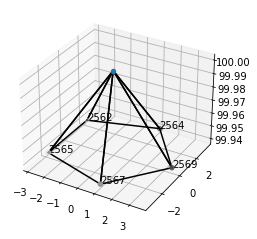

In [214]:

triangles = surf['faces'][(surf['faces']==vertex).any(axis=1)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(surf['coords'][vertex,0],
          surf['coords'][vertex,1],
          surf['coords'][vertex,2],
          )

ax.scatter(surf['coords'][neighbours,0],
          surf['coords'][neighbours,1],
          surf['coords'][neighbours,2],
           c=np.arange(len(neighbours))  ,cmap='Greys'      )
for ni,n in enumerate(neighbours):
  
    ax.text(surf['coords'][n,0],
          surf['coords'][n,1],
          surf['coords'][n,2], n)
    
c=surf['coords']
for t in triangles:
    ax.plot([c[t[0],0],c[t[1],0]],
           [c[t[0],1],c[t[1],1]],
           [c[t[0],2],c[t[1],2]],c='k'
           )
    ax.plot([c[t[2],0],c[t[1],0]],
           [c[t[2],1],c[t[1],1]],
           [c[t[2],2],c[t[1],2]],c='k'
           )
    ax.plot([c[t[0],0],c[t[2],0]],
           [c[t[0],1],c[t[2],1]],
           [c[t[0],2],c[t[2],2]],c='k'
           )

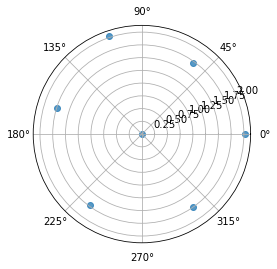

In [215]:
import matplotlib.pyplot as plt
e=icos.get_edges(6)
i=np.random.choice(800)
e_o = e[e[:,0]==i]
ed = icos.get_edge_vectors(6,dist_dtype='exact')
ed_o = ed[e[:,0]==i]
ed_o[:,1]
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(ed_o[:,0],ed_o[:,1],  cmap='hsv', alpha=0.75)


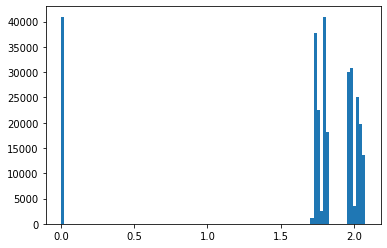

In [223]:
plt.hist(ed[:,1],100);

In [149]:


def find_distance(arr1, arr2):
    return np.arccos(np.dot(arr1, arr2))



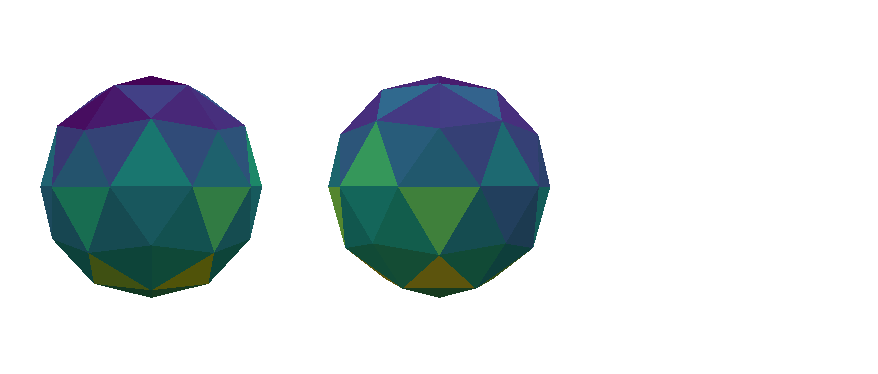

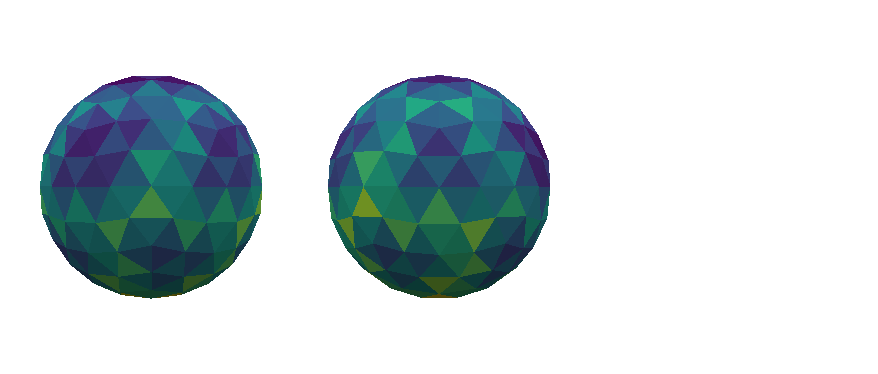

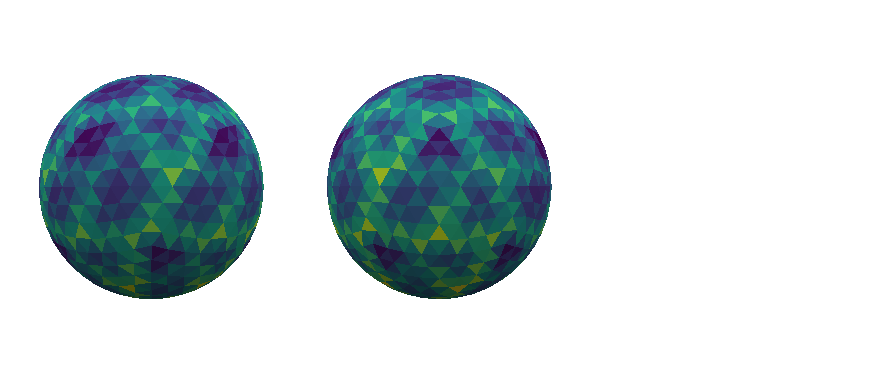

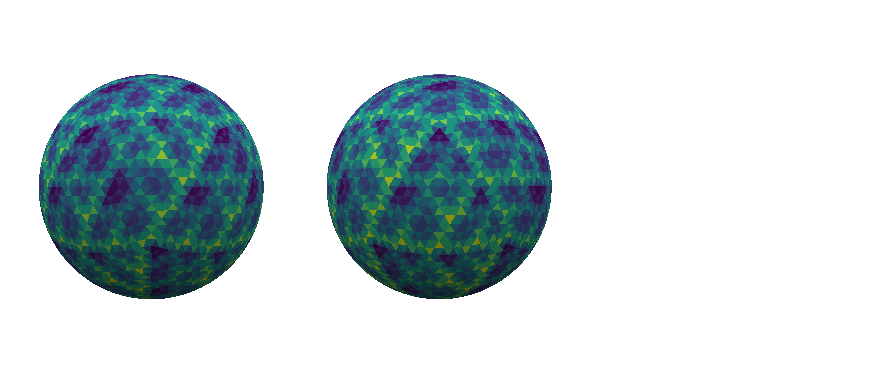

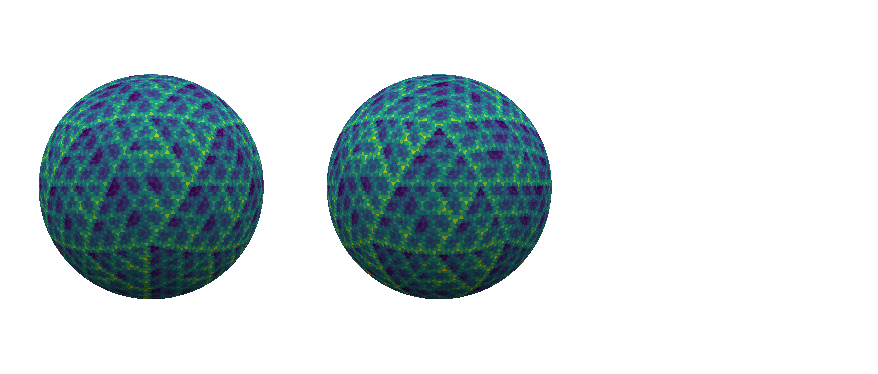

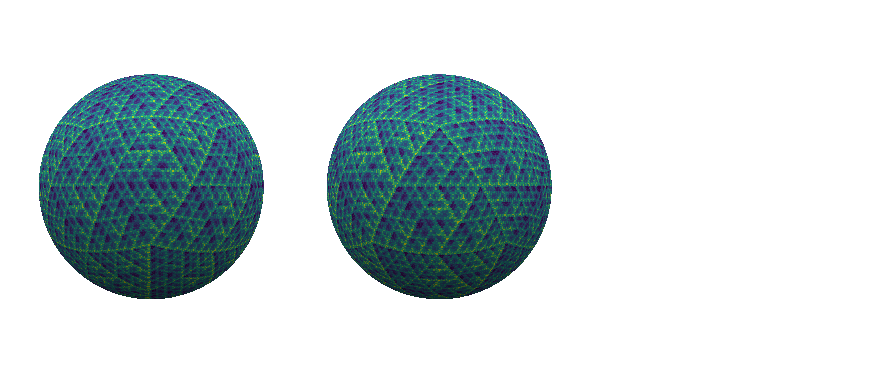

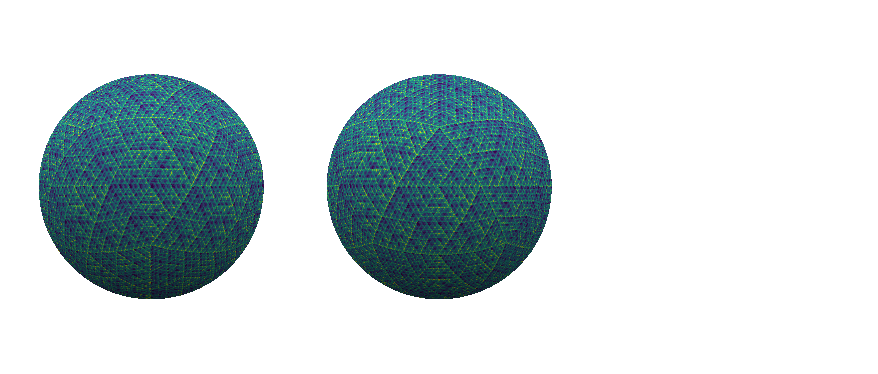

In [9]:
#load coordinates & spherical coordinates
for v in np.arange(7):
    msp.plot_surf(icos.icospheres[v+1]['coords'],
                 icos.icospheres[v+1]['faces'],
                  np.arange(len(icos.icospheres[v+1]['coords'])),
                  colorbar=False
                 )

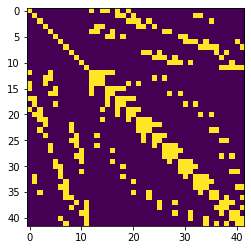

In [107]:
plt.imshow(icos.icospheres[1]['adj_mat'].toarray())